# 01_data_exploration_and_feature_engineering — FINAL

**Purpose:** Complete EDA and provider-level feature engineering for the Healthcare Provider Fraud Detection project. This notebook includes dataset relationships, data-quality checks, exploratory analysis, fraud vs. non-fraud comparisons, a recommended aggregation strategy, and export of provider-level features.

**Notes:** Update file paths if your CSVs are stored in a different location.

## 0. Environment & Instructions
- This notebook expects the CSV files in the same folder or provide full paths for these filenames:
  - `Train_Beneficiarydata.csv`
  - `Train_Inpatientdata.csv`
  - `Train_Outpatientdata.csv`
  - `Train_labels.csv`
- The notebook uses pandas and matplotlib for plotting.

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

## 2. Load datasets

In [3]:
files = {
    'benef':'Train_Beneficiarydata-1542865627584.csv',
    'inpat':'Train_Inpatientdata-1542865627584.csv',
    'outpat':'Train_Outpatientdata-1542865627584.csv',
    'labels':'Train-1542865627584.csv'
}
for k,v in files.items():
    print(k, '->', v, 'exists=', os.path.exists(v))

benef = pd.read_csv(files['benef'])
inpat = pd.read_csv(files['inpat'])
outpat = pd.read_csv(files['outpat'])
labels = pd.read_csv(files['labels'])

print('Loaded shapes:')
print('benef', benef.shape)
print('inpat', inpat.shape)
print('outpat', outpat.shape)
print('labels', labels.shape)

benef -> Train_Beneficiarydata-1542865627584.csv exists= True
inpat -> Train_Inpatientdata-1542865627584.csv exists= True
outpat -> Train_Outpatientdata-1542865627584.csv exists= True
labels -> Train-1542865627584.csv exists= True
Loaded shapes:
benef (125524, 25)
inpat (40474, 30)
outpat (69868, 27)
labels (5410, 2)


## 3. Relationship & Granularity
**Relationships (join keys):**
- `BeneID` links beneficiary table to inpatient & outpatient claim tables.
- `Provider` in claim tables links to labels table which has one row per provider.

**Granularity:**
- Beneficiary table: one row per patient.
- Claims: one row per claim event.
- Labels: one row per provider.

## 4. Basic data quality checks

In [4]:
def basic_checks(df, name):
    print('\n----', name, '----')
    print('shape:', df.shape)
    print('duplicates:', df.duplicated().sum())
    print('missing (top 20):')
    print(df.isna().sum().sort_values(ascending=False).head(20))
    display(df.describe(include='all').T)

basic_checks(benef, 'Beneficiary')
basic_checks(inpat, 'Inpatient')
basic_checks(outpat, 'Outpatient')
basic_checks(labels, 'Labels')


---- Beneficiary ----
shape: (125524, 25)
duplicates: 0
missing (top 20):
DOD                                124223
County                                  1
Gender                                  1
Race                                    1
RenalDiseaseIndicator                   1
NoOfMonths_PartACov                     1
State                                   1
ChronicCond_Alzheimer                   1
NoOfMonths_PartBCov                     1
ChronicCond_IschemicHeart               1
ChronicCond_Osteoporasis                1
ChronicCond_Heartfailure                1
ChronicCond_KidneyDisease               1
ChronicCond_Cancer                      1
ChronicCond_ObstrPulmonary              1
ChronicCond_Depression                  1
ChronicCond_Diabetes                    1
IPAnnualReimbursementAmt                1
IPAnnualDeductibleAmt                   1
ChronicCond_rheumatoidarthritis         1
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
BeneID,125524,125524,BENE145251,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOB,125524,900,1941-10-01,491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOD,1301,11,2009-12-01,171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,125523.0,NaN,NaN,NaN,1.570557,0.494999,1.0,1.0,2.0,2.0,2.0
Race,125523.0,NaN,NaN,NaN,1.253531,0.715611,1.0,1.0,1.0,1.0,5.0
RenalDiseaseIndicator,125523,2,0,107757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,125523.0,NaN,NaN,NaN,25.687261,15.217126,1.0,11.0,25.0,39.0,54.0
County,125523.0,NaN,NaN,NaN,374.634991,266.373257,0.0,141.0,340.0,570.0,999.0
NoOfMonths_PartACov,125523.0,NaN,NaN,NaN,11.906758,1.037807,0.0,12.0,12.0,12.0,12.0
NoOfMonths_PartBCov,125523.0,NaN,NaN,NaN,11.90969,0.939004,0.0,12.0,12.0,12.0,12.0



---- Inpatient ----
shape: (40474, 30)
duplicates: 0
missing (top 20):
ClmProcedureCode_6     40474
ClmProcedureCode_5     40465
ClmProcedureCode_4     40358
ClmProcedureCode_3     39509
ClmDiagnosisCode_10    36547
OtherPhysician         35784
ClmProcedureCode_2     35020
ClmProcedureCode_1     17326
OperatingPhysician     16644
ClmDiagnosisCode_9     13497
ClmDiagnosisCode_8      9942
ClmDiagnosisCode_7      7258
ClmDiagnosisCode_6      4838
ClmDiagnosisCode_5      2894
ClmDiagnosisCode_4      1534
DeductibleAmtPaid        899
ClmDiagnosisCode_3       676
ClmDiagnosisCode_2       226
AttendingPhysician       112
DischargeDt                0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
BeneID,40474,31289,BENE134170,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClaimID,40474,40474,CLM69948,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClaimStartDt,40474,398,2009-02-10,145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClaimEndDt,40474,365,2009-02-11,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Provider,40474,2092,PRV52019,516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InscClaimAmtReimbursed,40474.0,NaN,NaN,NaN,10087.884074,10303.099402,0.0,4000.0,7000.0,12000.0,125000.0
AttendingPhysician,40362,11604,PHY422134,386,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OperatingPhysician,23830,8287,PHY429430,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OtherPhysician,4690,2877,PHY416093,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AdmissionDt,40474,398,2009-02-10,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN



---- Outpatient ----
shape: (69868, 27)
duplicates: 0
missing (top 20):
ClmProcedureCode_5       69868
ClmProcedureCode_6       69868
ClmProcedureCode_3       69867
ClmProcedureCode_4       69867
ClmProcedureCode_2       69860
ClmProcedureCode_1       69854
ClmDiagnosisCode_10      69717
ClmDiagnosisCode_9       67862
ClmDiagnosisCode_8       66766
ClmDiagnosisCode_7       65407
ClmDiagnosisCode_6       63262
ClmDiagnosisCode_5       59777
OperatingPhysician       57632
ClmAdmitDiagnosisCode    55708
ClmDiagnosisCode_4       52901
OtherPhysician           43687
ClmDiagnosisCode_3       42363
ClmDiagnosisCode_2       26288
ClmDiagnosisCode_1        1395
AttendingPhysician         173
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
BeneID,69868,17993,BENE28733,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClaimID,69868,69868,CLM549729,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClaimStartDt,69868,385,2009-01-19,239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClaimEndDt,69868,365,2009-09-06,237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Provider,69868,4134,PRV51459,1107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InscClaimAmtReimbursed,69868.0,NaN,NaN,NaN,284.358505,780.190754,0.0,40.0,80.0,200.0,102500.0
AttendingPhysician,69695,24697,PHY330576,342,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OperatingPhysician,12236,7350,PHY330576,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OtherPhysician,26181,12312,PHY412132,202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClmDiagnosisCode_1,68473,7245,4019,1826,NaN,NaN,NaN,NaN,NaN,NaN,NaN



---- Labels ----
shape: (5410, 2)
duplicates: 0
missing (top 20):
Provider          0
PotentialFraud    0
dtype: int64


,count,unique,top,freq
Provider,5410,5410,PRV57763,1
PotentialFraud,5410,2,No,4904


### 4.1 Date parsing and logical checks

In [ ]:
from dateutil import parser
for df,name in [(benef,'benef'),(inpat,'inpat'),(outpat,'outpat')]:
    print('\nDataset', name)
    for col in df.columns:
        sample = df[col].dropna().astype(str).head(5).tolist()
        if any(['-' in s or '/' in s or ':' in s for s in sample]):
            print(' candidate date-like:', col)

# Try parsing common date columns
for col in ['DOB','DOD','ClaimDate','ClaimStartDt','ClaimEndDt','ServiceDate']:
    if col in benef.columns:
        benef[col] = pd.to_datetime(benef[col], errors='coerce')
        print('benef parsed', col, 'nulls:', benef[col].isna().sum())
    if col in inpat.columns:
        inpat[col] = pd.to_datetime(inpat[col], errors='coerce')
        print('inpat parsed', col, 'nulls:', inpat[col].isna().sum())
    if col in outpat.columns:
        outpat[col] = pd.to_datetime(outpat[col], errors='coerce')
        print('outpat parsed', col, 'nulls:', outpat[col].isna().sum())

# Example logical check for claims after death
if 'DOD' in benef.columns and 'ClaimDate' in inpat.columns:
    dead = benef[['BeneID','DOD']].dropna()
    merged = inpat.merge(dead, on='BeneID', how='inner')
    after = merged[merged['ClaimDate'] > merged['DOD']]
    print('inpatient claims after death:', after.shape[0])
if 'DOD' in benef.columns and 'ClaimDate' in outpat.columns:
    dead = benef[['BeneID','DOD']].dropna()
    merged = outpat.merge(dead, on='BeneID', how='inner')
    after = merged[merged['ClaimDate'] > merged['DOD']]
    print('outpatient claims after death:', after.shape[0])

## 5. Exploratory Analysis — Beneficiaries

age stats:


,age
count,125524.000000
mean,89.134843
std,12.739284
min,42.000000
25%,84.000000
50%,90.000000
75%,97.000000
max,116.000000


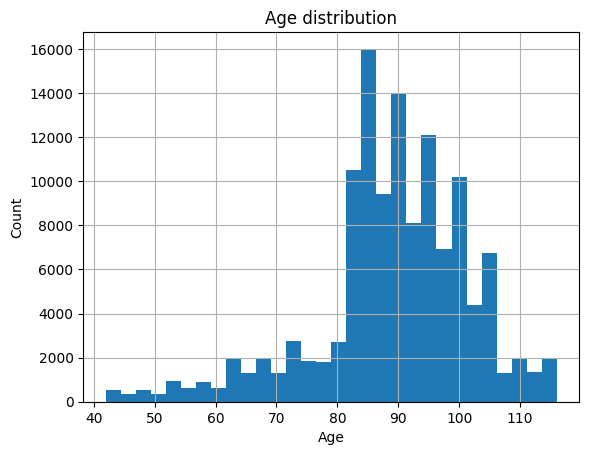

In [16]:
if 'DOB' in benef.columns:
    # Ensure DOB is datetime type for age calculation
    benef['DOB'] = pd.to_datetime(benef['DOB'], errors='coerce')
    today = pd.Timestamp('today')
    benef['age'] = (today - benef['DOB']).dt.days // 365
    print('age stats:')
    display(benef['age'].describe())
    plt.figure()
    benef['age'].dropna().hist(bins=30)
    plt.title('Age distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()

In [15]:
import pandas as pd

# Ensure benef DataFrame exists and has a 'DOB' column
# (Assuming 'benef' is already loaded from previous cells)

# Define 'today' if not already defined
today = pd.Timestamp('today')

# Convert 'DOB' to datetime, handling errors by coercing invalid dates to NaT
benef['DOB'] = pd.to_datetime(benef['DOB'], errors='coerce')

# Calculate age
benef['age'] = (today - benef['DOB']).dt.days // 365

print('Age column created/updated.')
display(benef[['BeneID', 'DOB', 'age']].head())

Age column created/updated.


,BeneID,DOB,age
0,BENE11001,1943-01-01,82
1,BENE11002,1936-09-01,89
2,BENE11003,1936-08-01,89
3,BENE11004,1922-07-01,103
4,BENE11005,1935-09-01,90


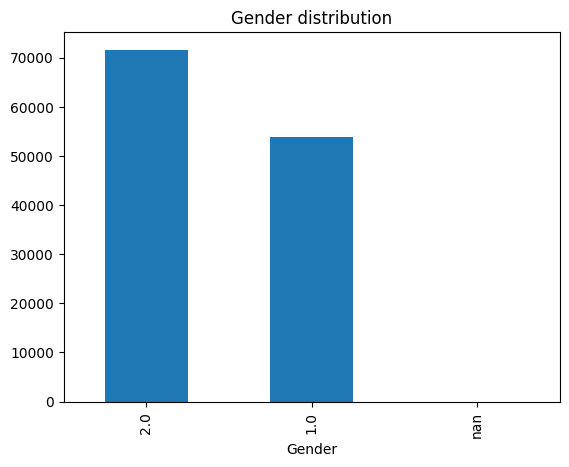

In [12]:
if 'Gender' in benef.columns:
    plt.figure()
    benef['Gender'].value_counts(dropna=False).plot(kind='bar')
    plt.title('Gender distribution')
    plt.show()

chronic-like columns: ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']


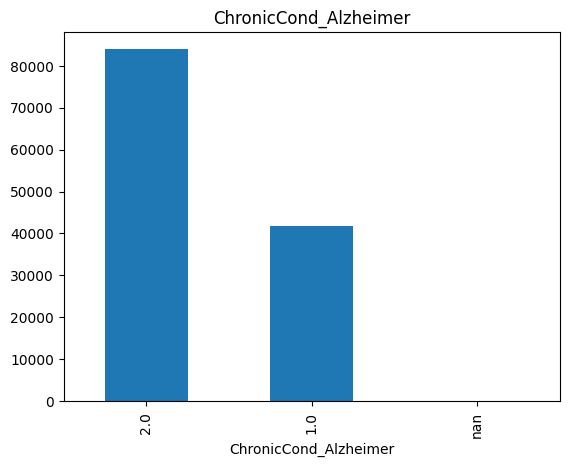

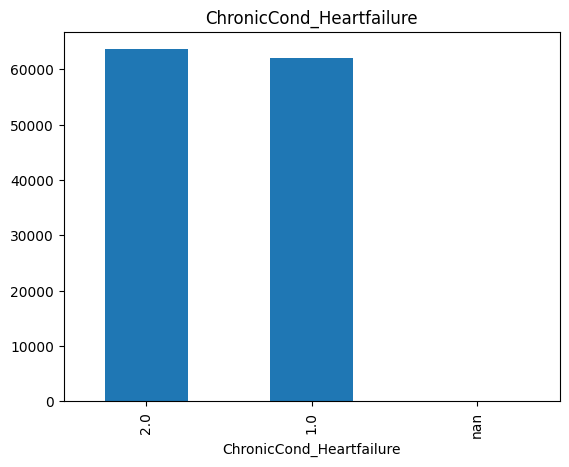

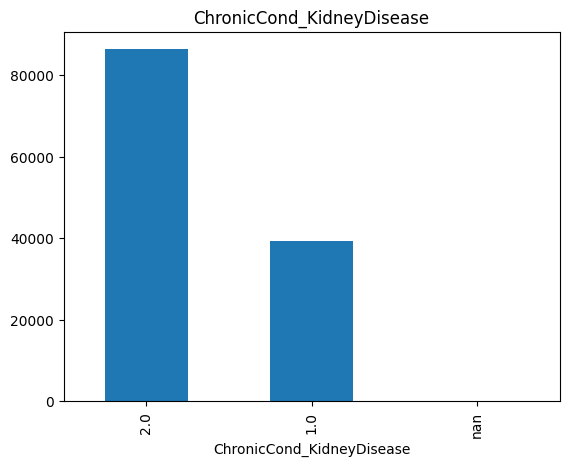

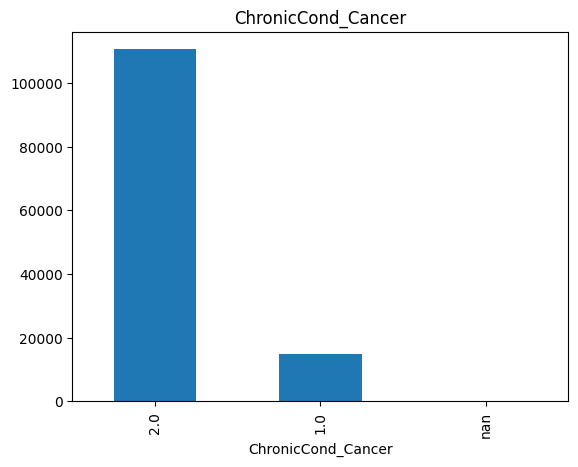

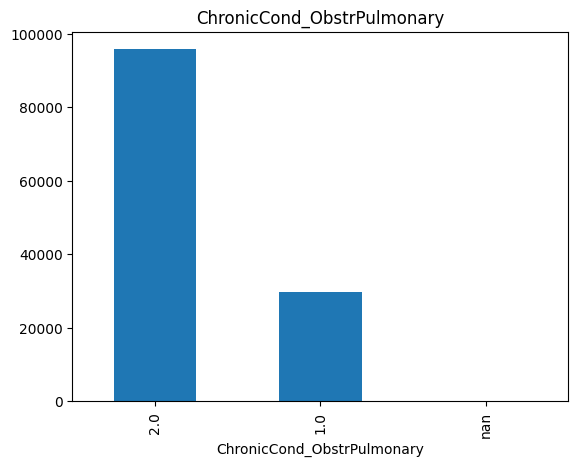

In [10]:
chronic_cols = [c for c in benef.columns if 'Chronic' in c or 'chronic' in c or 'Condition' in c]
print('chronic-like columns:', chronic_cols)
for c in chronic_cols[:5]:
    plt.figure()
    benef[c].value_counts(dropna=False).head(20).plot(kind='bar')
    plt.title(c)
    plt.show()

## 6. Exploratory Analysis — Claims

inpatient amount-like: ['InscClaimAmtReimbursed', 'DeductibleAmtPaid']


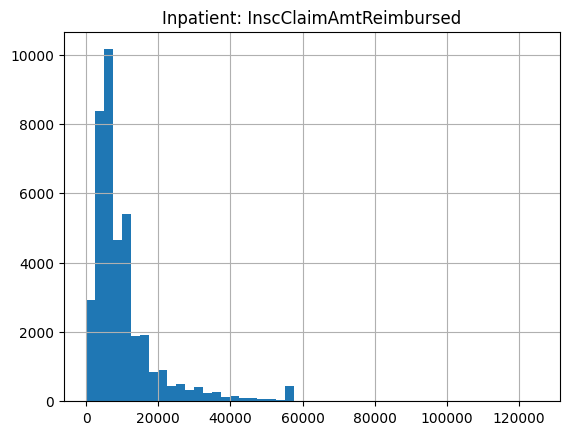

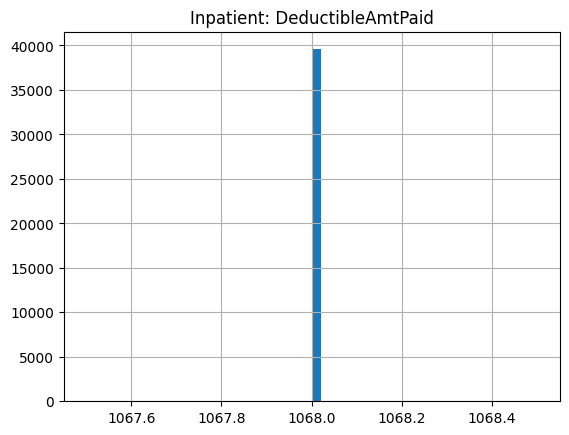

outpatient amount-like: ['InscClaimAmtReimbursed', 'DeductibleAmtPaid']


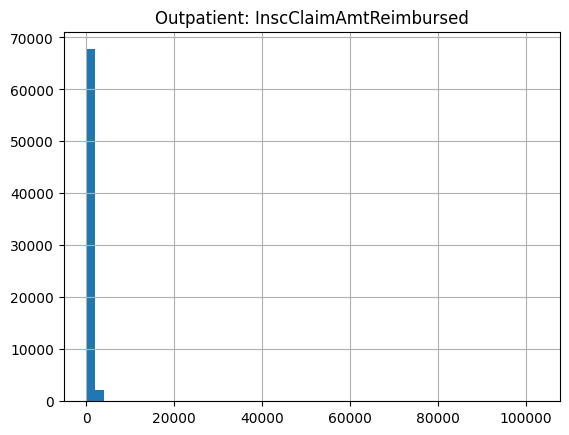

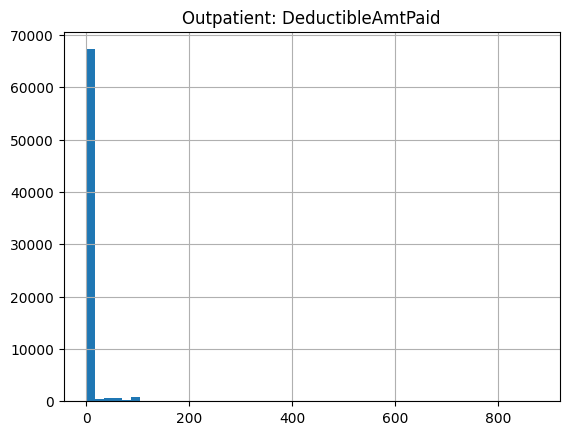

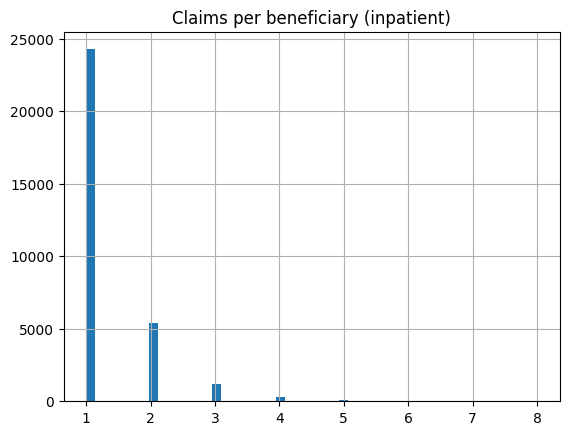

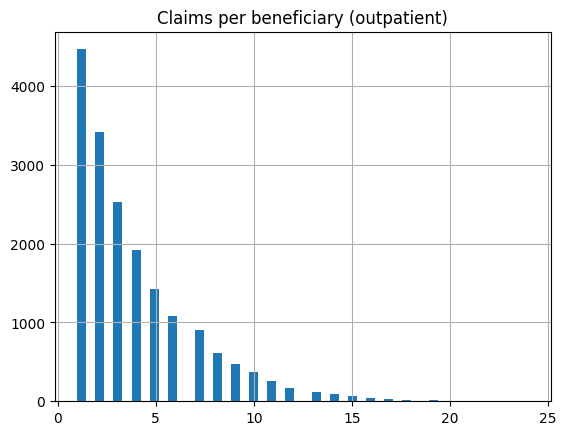

inpatient top 10 providers:


,0
Provider,
PRV52019,516
PRV55462,386
PRV54367,322
PRV53706,282
PRV55209,275
PRV56560,248
PRV54742,231
PRV55230,225
PRV52340,224


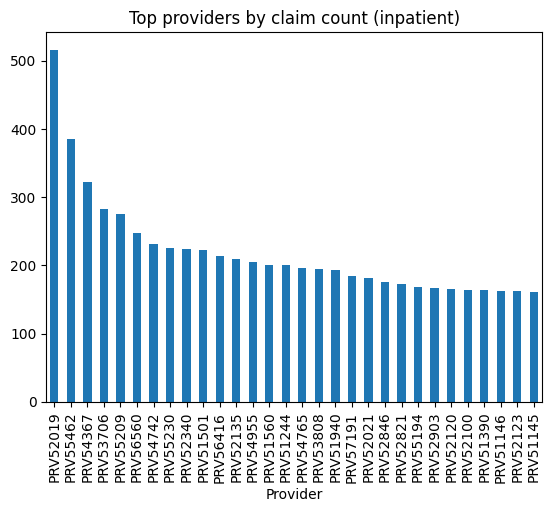

outpatient top 10 providers:


,0
Provider,
PRV51459,1107
PRV53797,760
PRV54895,561
PRV51574,536
PRV53918,472
PRV55215,445
PRV56011,396
PRV52064,340
PRV52030,334


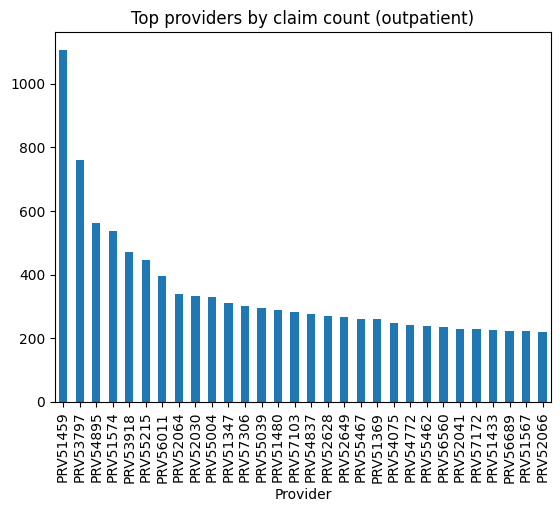

In [17]:
amt_cols = [c for c in inpat.columns if 'Amt' in c or 'Reimb' in c or 'Amount' in c]
print('inpatient amount-like:', amt_cols)
for c in amt_cols[:5]:
    plt.figure()
    inpat[c].dropna().astype(float).hist(bins=50)
    plt.title('Inpatient: '+c)
    plt.show()

amt_cols_out = [c for c in outpat.columns if 'Amt' in c or 'Reimb' in c or 'Amount' in c]
print('outpatient amount-like:', amt_cols_out)
for c in amt_cols_out[:5]:
    plt.figure()
    outpat[c].dropna().astype(float).hist(bins=50)
    plt.title('Outpatient: '+c)
    plt.show()

for df,name in [(inpat,'inpatient'),(outpat,'outpatient')]:
    if 'BeneID' in df.columns:
        grp = df.groupby('BeneID').size()
        plt.figure()
        grp.hist(bins=50)
        plt.title('Claims per beneficiary ('+name+')')
        plt.show()

for df,name in [(inpat,'inpatient'),(outpat,'outpatient')]:
    if 'Provider' in df.columns:
        grp = df.groupby('Provider').size().sort_values(ascending=False)
        print(name, 'top 10 providers:')
        display(grp.head(10))
        plt.figure()
        grp.head(30).plot(kind='bar')
        plt.title('Top providers by claim count ('+name+')')
        plt.show()

## 7. Labels inspection

In [ ]:
print('labels columns:', labels.columns.tolist())
labels.head()

## 8. Aggregation Strategy — Provider-level features

In [ ]:
# heuristic amount column names
in_amt = None
out_amt = None
for c in inpat.columns:
    if 'reimb' in c.lower() or 'amt' in c.lower() or 'amount' in c.lower():
        in_amt = c; break
for c in outpat.columns:
    if 'reimb' in c.lower() or 'amt' in c.lower() or 'amount' in c.lower():
        out_amt = c; break
print('detected amount columns ->', in_amt, out_amt)

def to_numeric_safe(s):
    return pd.to_numeric(s, errors='coerce')

# merge age if available
if 'age' in benef.columns and 'BeneID' in inpat.columns:
    inpat = inpat.merge(benef[['BeneID','age']], on='BeneID', how='left')
if 'age' in benef.columns and 'BeneID' in outpat.columns:
    outpat = outpat.merge(benef[['BeneID','age']], on='BeneID', how='left')

# mark after_death if DOD and ClaimDate exist
if 'DOD' in benef.columns and 'ClaimDate' in inpat.columns:
    inpat = inpat.merge(benef[['BeneID','DOD']], on='BeneID', how='left')
    inpat['after_death'] = inpat['ClaimDate'] > inpat['DOD']
if 'DOD' in benef.columns and 'ClaimDate' in outpat.columns:
    outpat = outpat.merge(benef[['BeneID','DOD']], on='BeneID', how='left')
    outpat['after_death'] = outpat['ClaimDate'] > outpat['DOD']

# inpatient aggregation
grp_in = inpat.groupby('Provider').agg(inpatient_claim_count=('Provider','count'))
if in_amt:
    inpat[in_amt] = to_numeric_safe(inpat[in_amt])
    gin = inpat.groupby('Provider')[in_amt].agg(['sum','mean','std']).rename(columns={'sum':'in_sum_amt','mean':'in_mean_amt','std':'in_std_amt'})
    grp_in = grp_in.join(gin)
if 'BeneID' in inpat.columns:
    grp_in['in_unique_benes'] = inpat.groupby('Provider')['BeneID'].nunique()
if 'age' in inpat.columns:
    grp_in['in_mean_age'] = inpat.groupby('Provider')['age'].mean()
if 'after_death' in inpat.columns:
    grp_in['in_after_death_pct'] = inpat.groupby('Provider')['after_death'].mean()

# outpatient aggregation
grp_out = outpat.groupby('Provider').agg(outpatient_claim_count=('Provider','count'))
if out_amt:
    outpat[out_amt] = to_numeric_safe(outpat[out_amt])
    gout = outpat.groupby('Provider')[out_amt].agg(['sum','mean','std']).rename(columns={'sum':'out_sum_amt','mean':'out_mean_amt','std':'out_std_amt'})
    grp_out = grp_out.join(gout)
if 'BeneID' in outpat.columns:
    grp_out['out_unique_benes'] = outpat.groupby('Provider')['BeneID'].nunique()
if 'age' in outpat.columns:
    grp_out['out_mean_age'] = outpat.groupby('Provider')['age'].mean()
if 'after_death' in outpat.columns:
    grp_out['out_after_death_pct'] = outpat.groupby('Provider')['after_death'].mean()

# combine
prov = grp_in.join(grp_out, how='outer').fillna(0)
prov['total_claim_count'] = prov.get('inpatient_claim_count',0) + prov.get('outpatient_claim_count',0)
prov['total_sum_amt'] = prov.get('in_sum_amt',0) + prov.get('out_sum_amt',0)
prov['mean_amt_overall'] = prov['total_sum_amt'] / prov['total_claim_count'].replace(0, np.nan)
prov['mean_amt_overall'] = prov['mean_amt_overall'].fillna(0)
prov['pct_inpatient'] = np.where(prov['total_claim_count']>0, prov.get('inpatient_claim_count',0)/prov['total_claim_count'], 0)
prov['unique_beneficiaries'] = prov.get('in_unique_benes',0) + prov.get('out_unique_benes',0)

# join labels
if 'Provider' in labels.columns:
    labels_idx = labels.set_index('Provider')
else:
    labels_idx = labels.set_index(labels.columns[0])
prov = prov.join(labels_idx, how='left')
print('provider-level shape:', prov.shape)
prov.head()

## 9. Visual comparisons (Fraud vs Non-Fraud)

detected amount columns -> InscClaimAmtReimbursed InscClaimAmtReimbursed
provider-level shape: (4670, 18)
label column: PotentialFraud


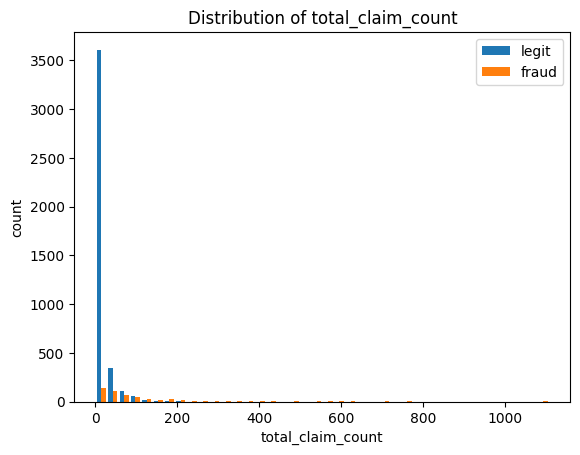

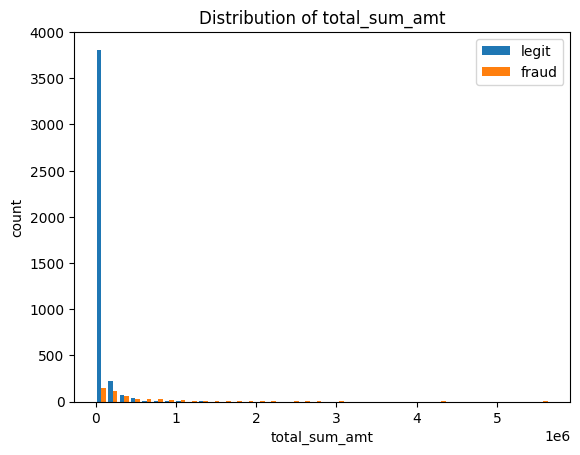

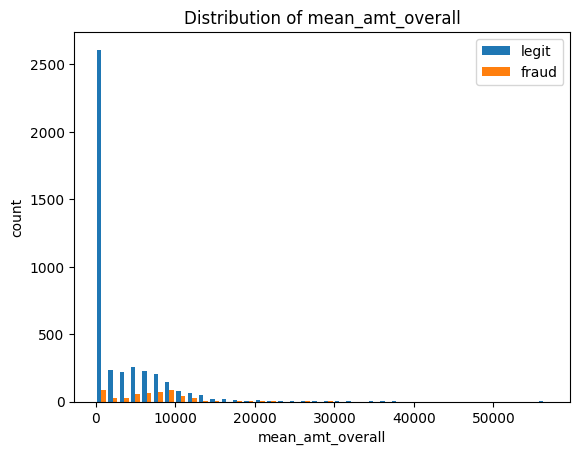

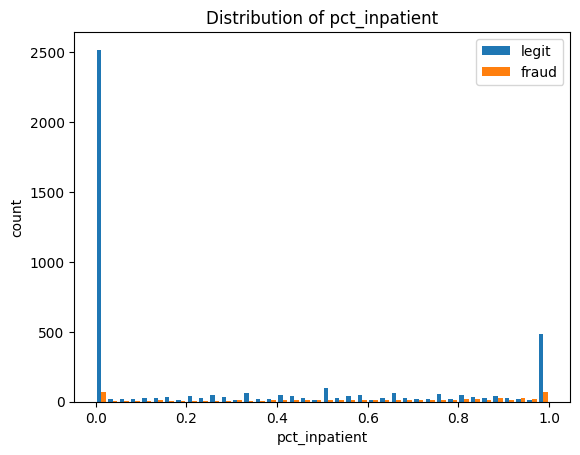

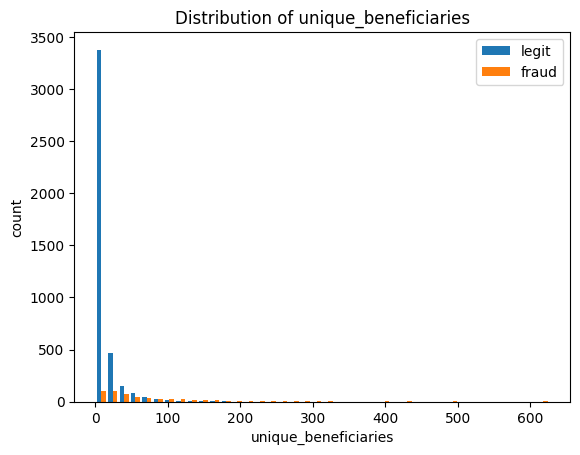

In [19]:
# heuristic amount column names
in_amt = None
out_amt = None
for c in inpat.columns:
    if 'reimb' in c.lower() or 'amt' in c.lower() or 'amount' in c.lower():
        in_amt = c; break
for c in outpat.columns:
    if 'reimb' in c.lower() or 'amt' in c.lower() or 'amount' in c.lower():
        out_amt = c; break
print('detected amount columns ->', in_amt, out_amt)

def to_numeric_safe(s):
    return pd.to_numeric(s, errors='coerce')

# merge age if available
if 'age' in benef.columns and 'BeneID' in inpat.columns:
    inpat = inpat.merge(benef[['BeneID','age']], on='BeneID', how='left')
if 'age' in benef.columns and 'BeneID' in outpat.columns:
    outpat = outpat.merge(benef[['BeneID','age']], on='BeneID', how='left')

# mark after_death if DOD and ClaimDate exist
if 'DOD' in benef.columns and 'ClaimDate' in inpat.columns:
    inpat = inpat.merge(benef[['BeneID','DOD']], on='BeneID', how='left')
    inpat['after_death'] = inpat['ClaimDate'] > inpat['DOD']
if 'DOD' in benef.columns and 'ClaimDate' in outpat.columns:
    outpat = outpat.merge(benef[['BeneID','DOD']], on='BeneID', how='left')
    outpat['after_death'] = outpat['ClaimDate'] > outpat['DOD']

# inpatient aggregation
grp_in = inpat.groupby('Provider').agg(inpatient_claim_count=('Provider','count'))
if in_amt:
    inpat[in_amt] = to_numeric_safe(inpat[in_amt])
    gin = inpat.groupby('Provider')[in_amt].agg(['sum','mean','std']).rename(columns={'sum':'in_sum_amt','mean':'in_mean_amt','std':'in_std_amt'})
    grp_in = grp_in.join(gin)
if 'BeneID' in inpat.columns:
    grp_in['in_unique_benes'] = inpat.groupby('Provider')['BeneID'].nunique()
if 'age' in inpat.columns:
    grp_in['in_mean_age'] = inpat.groupby('Provider')['age'].mean()
if 'after_death' in inpat.columns:
    grp_in['in_after_death_pct'] = inpat.groupby('Provider')['after_death'].mean()

# outpatient aggregation
grp_out = outpat.groupby('Provider').agg(outpatient_claim_count=('Provider','count'))
if out_amt:
    outpat[out_amt] = to_numeric_safe(outpat[out_amt])
    gout = outpat.groupby('Provider')[out_amt].agg(['sum','mean','std']).rename(columns={'sum':'out_sum_amt','mean':'out_mean_amt','std':'out_std_amt'})
    grp_out = grp_out.join(gout)
if 'BeneID' in outpat.columns:
    grp_out['out_unique_benes'] = outpat.groupby('Provider')['BeneID'].nunique()
if 'age' in outpat.columns:
    grp_out['out_mean_age'] = outpat.groupby('Provider')['age'].mean()
if 'after_death' in outpat.columns:
    grp_out['out_after_death_pct'] = outpat.groupby('Provider')['after_death'].mean()

# combine
prov = grp_in.join(grp_out, how='outer').fillna(0)
prov['total_claim_count'] = prov.get('inpatient_claim_count',0) + prov.get('outpatient_claim_count',0)
prov['total_sum_amt'] = prov.get('in_sum_amt',0) + prov.get('out_sum_amt',0)
prov['mean_amt_overall'] = prov['total_sum_amt'] / prov['total_claim_count'].replace(0, np.nan)
prov['mean_amt_overall'] = prov['mean_amt_overall'].fillna(0)
prov['pct_inpatient'] = np.where(prov['total_claim_count']>0, prov.get('inpatient_claim_count',0)/prov['total_claim_count'], 0)
prov['unique_beneficiaries'] = prov.get('in_unique_benes',0) + prov.get('out_unique_benes',0)

# join labels
if 'Provider' in labels.columns:
    labels_idx = labels.set_index('Provider')
else:
    labels_idx = labels.set_index(labels.columns[0])
prov = prov.join(labels_idx, how='left')
print('provider-level shape:', prov.shape)
prov.head()

# detect label column
labcol = None
for c in prov.columns:
    if 'fraud' in str(c).lower() or 'potential' in str(c).lower():
        labcol = c
        break
if labcol is None:
    for c in labels.columns:
        if 'fraud' in str(c).lower() or 'potential' in str(c).lower():
            labcol = c
            break
print('label column:', labcol)
if labcol is None:
    labcol = labels.columns[0]

# normalize label
prov['_label_raw'] = prov[labcol].astype(str)
prov['_label'] = prov['_label_raw'].str.lower().map({'yes':'fraud','y':'fraud','1':'fraud','true':'fraud','no':'legit','n':'legit','0':'legit','false':'legit'}).fillna('legit')

for feat in ['total_claim_count','total_sum_amt','mean_amt_overall','pct_inpatient','unique_beneficiaries']:
    if feat in prov.columns:
        plt.figure()
        vals_legit = prov[prov['_label']=='legit'][feat].dropna()
        vals_fraud = prov[prov['_label']=='fraud'][feat].dropna()
        plt.hist([vals_legit, vals_fraud], bins=40)
        plt.legend(['legit','fraud'])
        plt.title('Distribution of '+feat)
        plt.xlabel(feat)
        plt.ylabel('count')
        plt.show()

## 10. Correlation matrix

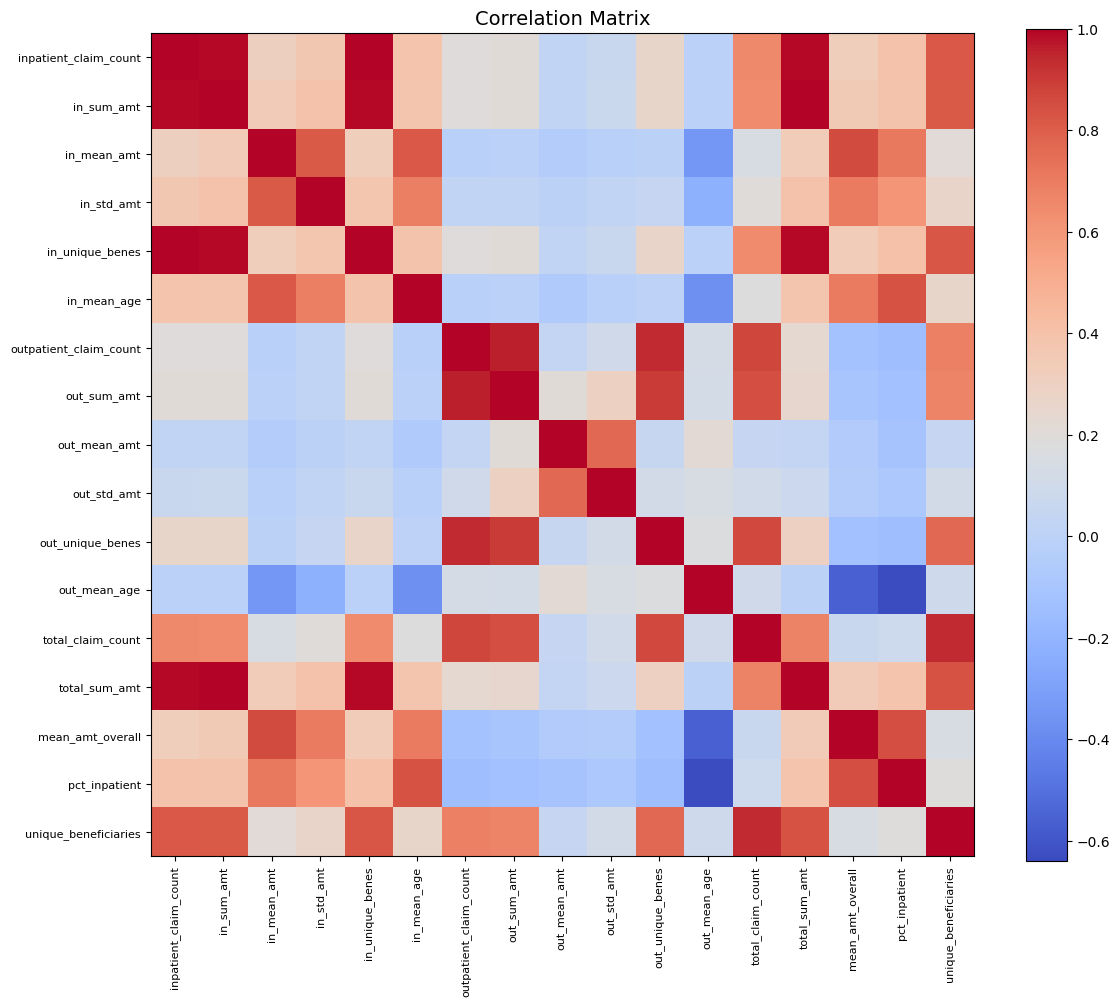

In [22]:
num = prov.select_dtypes(include=[np.number])

if not num.empty:
    corr = num.corr()

    plt.figure(figsize=(12, 10))
    plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
    plt.title("Correlation Matrix", fontsize=14)
    plt.colorbar()

    # X & Y ticks
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8)
    plt.yticks(range(len(corr.index)), corr.index, fontsize=8)

    plt.tight_layout()
    plt.show()

else:
    print("no numeric columns to correlate")


## 11. Temporal & Geographic patterns

In [23]:
if 'ProviderState' in inpat.columns or 'ProviderState' in outpat.columns:
    col = 'ProviderState'
    series = pd.concat([inpat[[col]].dropna(), outpat[[col]].dropna()])
    top = series[col].value_counts().head(20)
    plt.figure()
    top.plot(kind='bar')
    plt.title('Top provider states')
    plt.show()

if 'ClaimDate' in inpat.columns:
    inpat['year_month'] = inpat['ClaimDate'].dt.to_period('M')
    tm = inpat.groupby('year_month').size()
    plt.figure()
    tm.plot()
    plt.title('Inpatient claims over time')
    plt.show()

## 12. Export provider features

In [24]:
outfn = 'provider_features_final.csv'
prov.to_csv(outfn, index=True)
print('written', outfn, 'shape', prov.shape)

written provider_features_final.csv shape (4670, 20)


## 13. Next steps and recommendations
- Add text features, top procedure codes per provider, time-based aggregations.
- Use group-aware cross-validation and careful leakage checks.
- Try class weighting and sampling methods to handle imbalance.

---

**End of notebook.**